In [2]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

%matplotlib inline

#### Standard Atmosphere model

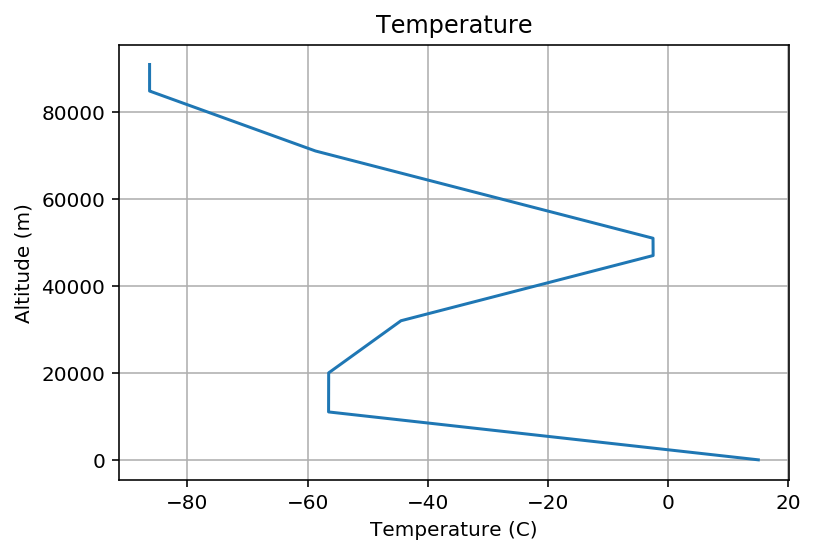

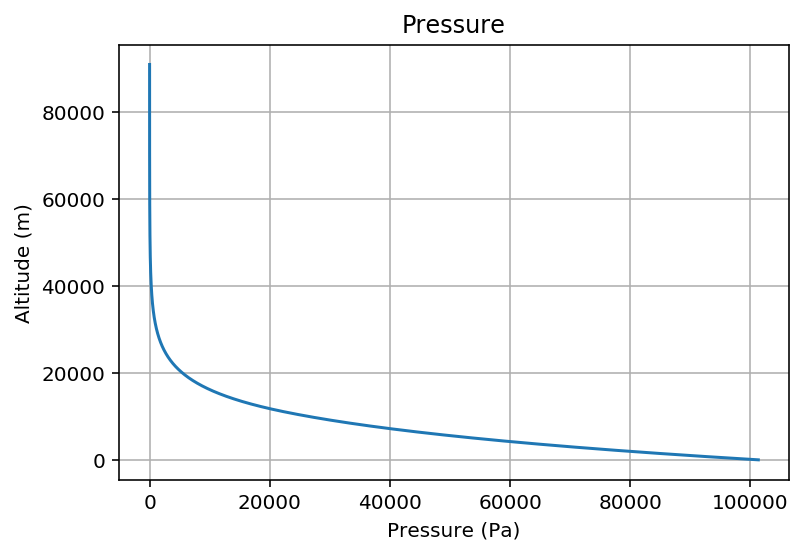

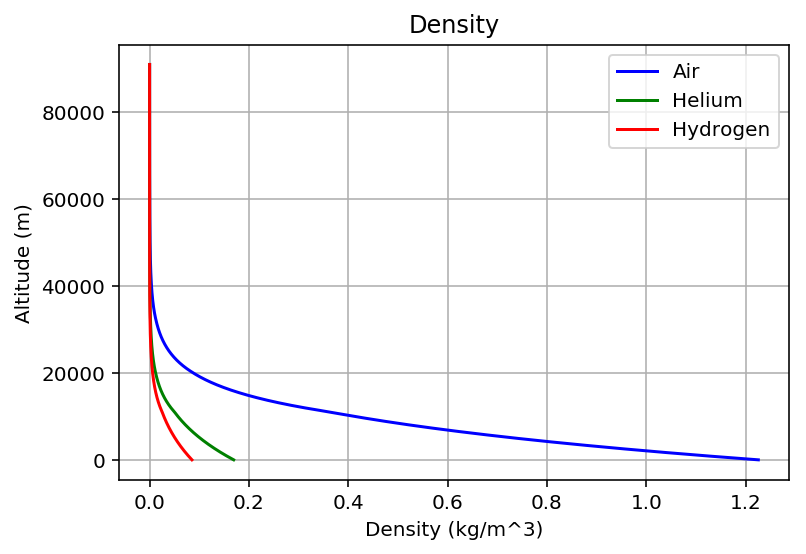

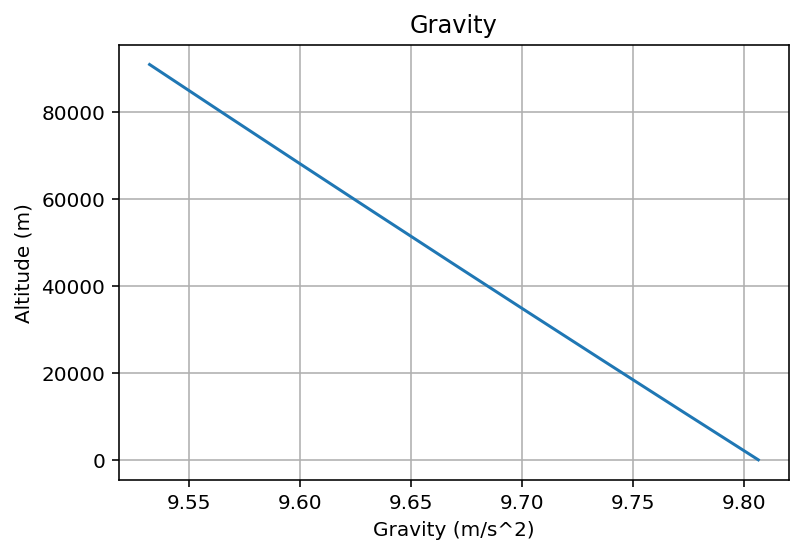

In [3]:
P0 = 101325.0            # Pa
T0 = 15.0                # °C
A0 = 340.294             # m/s
G0 = 9.80665             # m/s^2

Ttp = -56.5              # °C
Tsp = -2.5               # °C
Tmp = -86.28             # °C
a = -0.0065              # °C/m
b = 0.001                # °C/m
c = 0.0028               # °C/m
d = -0.0028              # °C/m
e = -0.002               # °C/m
n = 5.2561
Rair = 286.9             # J/(kg*K)
Rh = 4124                # J/(kg*K)
Rhe = 2077               # J/(kg*K)

maxAlt = 91000
H = np.arange(0,maxAlt,1) # m
T = np.zeros(maxAlt)      # °C
P = np.zeros(maxAlt)      # Pa
Da = np.zeros(maxAlt)     # kg/m^3
Dh = np.zeros(maxAlt)     # kg/m^3
Dhe = np.zeros(maxAlt)    # kg/m^3
G = np.zeros(maxAlt)      # m/s^2

for g in range(0,maxAlt):
    if g == 0:
        G[g] = G0
    else:
        G[g] = G0 * (6371008.8/(6371008.8 + H[g]))**2

for i in range(11000):
    if i == 0:
        T[i] = T0
        P[i] = P0
    else:
        T[i] = T[i-1] + a
        P[i] = P0 * ((T[i] + 273.15) / (T0 + 273.15))**(-G[0] / a / Rair)

for i in range(11000,20000):
    T[i] = Ttp
    P[i] = P[10999] * np.exp(-G[0] / Rair / (Ttp + 273.15) * (H[i] - 10999))

for i in range(20000,32000):
    T[i] = T[i-1] + b
    P[i] = P[19999] * ((T[i] + 273.15) / (Ttp + 273.15))**(-G[0] / b / Rair)

for i in range(32000,47000):
    T[i] = T[i-1] + c
    P[i] = P[31999] * ((T[i] + 273.15) / (T[31999] + 273.15))**(-G[0] / c / Rair)

for i in range(47000,51000):
    T[i] = Tsp
    P[i] = P[46999] * np.exp(-G[0] / Rair / (Tsp + 273.15) * (H[i] - 46999))

for i in range(51000,71000):
    T[i] = T[i-1] + d
    P[i] = P[50999] * ((T[i] + 273.15) / (T[50999] + 273.15))**(-G[0] / d / Rair)

for i in range(71000,84852):
    T[i] = T[i-1] + e
    P[i] = P[70999] * ((T[i] + 273.15) / (T[70999] + 273.15))**(-G[0] / e / Rair)

for i in range(84852,91000):
    T[i] = Tmp
    P[i] = P[84851] * np.exp(-G[0] / Rair / (Tmp + 273.15) * (H[i] - 84851))

for d in range(0,maxAlt):
    Da[d] = P[d] / (Rair * (T[d] + 273.15))
    Dh[d] = P[d] / (Rh * (T[d] + 273.15))
    Dhe[d] = P[d] / (Rhe * (T[d] + 273.15))

plt.plot(T, H)
plt.title('Temperature')
plt.xlabel('Temperature (C)')
plt.ylabel('Altitude (m)')
plt.grid()
plt.show()

plt.plot(P, H)
plt.title('Pressure')
plt.xlabel('Pressure (Pa)')
plt.ylabel('Altitude (m)')
plt.grid()
plt.show()

plt.plot(Da, H, 'b', label='Air')
plt.plot(Dhe, H, 'g', label='Helium')
plt.plot(Dh, H, 'r', label='Hydrogen')
plt.title('Density')
plt.xlabel('Density (kg/m^3)')
plt.ylabel('Altitude (m)')
plt.legend()
#plt.axis([0,0.2,0,91000])
plt.grid()
plt.show()

plt.plot(G, H)
plt.title('Gravity')
plt.xlabel('Gravity (m/s^2)')
plt.ylabel('Altitude (m)')
plt.grid()
plt.show()

#### Functions

In [4]:
def balloonParams(radius, thickness, filmDensity, payloadMass, LgasMass, liftingGas, superTemp):
    
    Bvolume = 4 / 3 * np.pi * radius**3
    Bmass = 4 * np.pi * radius**2 * (thickness / 1000000.0) * filmDensity

    if liftingGas is "hydrogen":
        FreeLift = LgasMass * (Da[0] - Dh[0]) * 8.31446 * (T[0] + 273.15) / P[0] / 0.002016 \
                 - payloadMass - Bmass
        gasConst = 4124.0
        
    elif liftingGas is "helium":
        FreeLift = LgasMass * (Da[0] - Dhe[0]) * 8.31446 * (T[0] + 273.15) / P[0] / 0.004003 \
                 - payloadMass - Bmass
        gasConst = 2077.0
    
    gasVolume = LgasMass * gasConst * (T[0] + 273.15) / P[0]
    Fb = gasVolume * (P[0] / (286.9 * (T[0] + 273.15))) * 9.81
    Fw = (LgasMass + payloadMass + Bmass) * 9.81
    Fr = Fb - Fw
    AirDensity = P[0] / (286.9 * (T[0] + 273.15))
    ascRate = np.sqrt((2 * Fr) / (0.47 * AirDensity * np.pi * \
                ((gasVolume * 3 / 4 / np.pi)**(1. / 3))**2))
    maxGasLoss = FreeLift / (FreeLift + payloadMass + Bmass) * 100
    systemDensity = (LgasMass + payloadMass + Bmass) / Bvolume
    
    for i in range(len(Da) - 1):
        if Da[i] is systemDensity:
            altitude = i
            break
        if Da[i] > systemDensity and Da[i+1] < systemDensity:
            altitude = i
            break
        else:
            altitude = 0
            
    altP = P[altitude]
    altT = T[altitude]
    superPressure = LgasMass * gasConst * (altT + 273.15 + superTemp) / Bvolume - altP
    Barea = 4 * np.pi * radius**2

    print("Balloon Radius:\t\t{0:.4f}\tm".format(radius))
    print("Balloon Volume:\t\t{0:.4f}\tm^3".format(Bvolume))
    print("Balloon Mass:\t\t{0:.4f}\tkg".format(Bmass))
    print("Payload Mass:\t\t{0:.1f}\tg".format(payloadMass * 1000))
    print("Gas Mass:\t\t{0:.3f}\tg".format(LgasMass * 1000))
    print("Free Lift:\t\t{0:.1f}\tg".format(FreeLift * 1000))
    print("Gas Volume:\t\t{0:.3f}\tm^3".format(gasVolume))
    print("Initial Buyoancy:\t{0:.3f}\tN".format(Fb))
    print("Initial Weight:\t\t{0:.3f}\tN".format(Fw))
    print("Resultant Force:\t{0:.3f}\tN".format(Fr))
    print("Air Density:\t\t{0:.3f}\tkg/m^3".format(AirDensity))
    print("Initial Ascent Rate:\t{0:.1f}\tm/s".format(ascRate))
    print("Float Altitude:\t\t{0:.0f}\tm".format(altitude))
    print("Float Alt. Pressure:\t{0:.0f}\tPa".format(altP))
    print("Float Alt. Temperature:\t{0:.1f}\t°C".format(altT))
    print("SuperTemperature:\t{0:.1f}\t°C".format(superTemp))
    print("SuperPressure:\t\t{0:.0f}\tPa".format(superPressure))
    print("Balloon Surface:\t{0:.3f}\tm^2".format(Barea))
    print("Maximum Gas Loss:\t{0:.2f}\t%".format(maxGasLoss))

In [5]:
def gasLoss(output, points, factor, bVolume, bMass, pMass, gMass, altitude, \
            gas, superT, permeability):
    
    # bVolume        m^3
    # bMass          kg
    # pMass          kg
    # gMass          kg
    # altitude       m
    # gas            'helium' or 'hydrogen'
    # superT         °C
    # permeability   cc/m^2/24hr/atm
    
    gasR = 0.0
    
    if gas is "hydrogen":
        gasR = 4124.0
    elif gas is "helium":
        gasR = 2077.0
    else:
        gasR = 4124.0
    
    alt = altitude
    pressure = 0.0
    temperature = 0.0
    ascentRate = 0.0
    gasMass = gMass
    volume = 0.0
    fLift = 0.0
    fWeight = 0.0
    gasLoss = 0.0
    superpressure = 0.0
    lostGas = 0.0
    
    bSurface = 4 * np.pi * ((bVolume * 3 / 4 / np.pi)**(1./3))**2
    
    pressure = P[int(alt)]
    temperature = T[int(alt)]
    gasLoss = (1.0 - (gasMass / gMass)) * 100.0
    
    if (gasMass * gasR * (temperature + 273.15) / pressure) > bVolume:
        volume = bVolume
    else:
        volume = gasMass * gasR * (temperature + 273.15) / pressure
          
    fLift = pressure / (286.9 * (temperature + 273.15)) * volume * 9.81
    fWeight = (gasMass + bMass + pMass) * 9.81
    superpressure = gasMass * gasR * (temperature + 273.15) / volume - pressure
    
    if superpressure < 0.0:
        superpressure = 0
    
    ascentRate = np.sqrt((2 * abs(fLift - fWeight)) / (0.47 * (pressure / \
                 (286.9 * (temperature + 273.15))) * (volume * 3 / 4)))
    
    if fLift < fWeight:
        ascentRate = ascentRate * (-1)
    
    alt = alt + ascentRate
    
    output[0][0] = altitude       # Altitude
    output[1][0] = ascentRate     # Ascent Rate
    output[2][0] = gMass          # Gas Mass
    output[3][0] = fLift          # Lift Force
    output[4][0] = fWeight        # Weight
    output[5][0] = gasLoss        # Gas Loss
    output[6][0] = superpressure  # Superpressure
    output[7][0] = lostGas        # total lost gas per day
    
    for i in range(1, points):
        
        if alt < 0:
            return i
        
        pressure = P[int(alt)]
        temperature = T[int(alt)]
        lostGas = (gasMass * gasR * (temperature + 273.15 + superT) / bVolume) / \
                    101325.0 * bSurface * permeability
        #lostGas = superpressure / 101325.0 * bSurface * permeability
        lostGasVol = lostGas / 1000000 / 86400.0 / bVolume
        gasMass = gasMass - (gasMass * lostGasVol)
        gasLoss = (1.0 - (gasMass / gMass)) * 100.0
        
        if (gasMass * gasR * (temperature + 273.15) / pressure) > bVolume:
            volume = bVolume
        else:
            volume = gasMass * gasR * (temperature + 273.15) / pressure
        
        fLift = pressure / (286.9 * (temperature + 273.15)) * volume * 9.81
        fWeight = (gasMass + bMass + pMass) * 9.81
        superpressure = gasMass * gasR * (temperature + 273.15 + superT) / bVolume - pressure
        
        if superpressure < 0.0:
            superpressure = 0
        
        ascentRate = np.sqrt((2 * abs(fLift - fWeight)) / (0.47 * (pressure / (286.9 * \
                    (temperature + 273.15))) * ((volume * 3 / 4 / np.pi)**(1. / 3))**2 * np.pi))
        
        if fLift < fWeight:
            ascentRate = ascentRate * (-1)
        
        alt = alt + ascentRate
        
        if i % factor == 0:
            
            output[0][int(i/factor)] = alt
            output[1][int(i/factor)] = ascentRate
            output[2][int(i/factor)] = gasMass
            output[3][int(i/factor)] = fLift
            output[4][int(i/factor)] = fWeight
            output[5][int(i/factor)] = gasLoss
            output[6][int(i/factor)] = superpressure
            output[7][int(i/factor)] = lostGas
    
    return points

#### To quickly get parameters for a specific balloon:

In [6]:
radius = 0.50            # balloon radius (m)
thickness = 25.4         # film thickness (μm)
filmDensity = 1390       # (kg/m^3)
payloadMass = 0.010      # (kg)
LgasMass = 0.020785      # (kg)
liftingGas = "helium"  # hydrogen/helium
superTemp = 20.0         # (°C)

balloonParams(radius, thickness, filmDensity, payloadMass, LgasMass, liftingGas, superTemp)

Balloon Radius:		0.5000	m
Balloon Volume:		0.5236	m^3
Balloon Mass:		0.1109	kg
Payload Mass:		10.0	g
Gas Mass:		20.785	g
Free Lift:		8.8	g
Gas Volume:		0.123	m^3
Initial Buyoancy:	1.476	N
Initial Weight:		1.390	N
Resultant Force:	0.086	N
Air Density:		1.226	kg/m^3
Initial Ascent Rate:	1.0	m/s
Float Altitude:		12875	m
Float Alt. Pressure:	16823	Pa
Float Alt. Temperature:	-56.5	°C
SuperTemperature:	20.0	°C
SuperPressure:		2689	Pa
Balloon Surface:	3.142	m^2
Maximum Gas Loss:	6.77	%


#### Model impact of gas diffusion on a balloon. (setup to calculate every second and output data every hour)

Maximum Altitude:	17738	m	(40 m difference)
Time to Max. Alt.:	5509	h	(229.5 days)
Gas Loss to Failure:	4.44	%


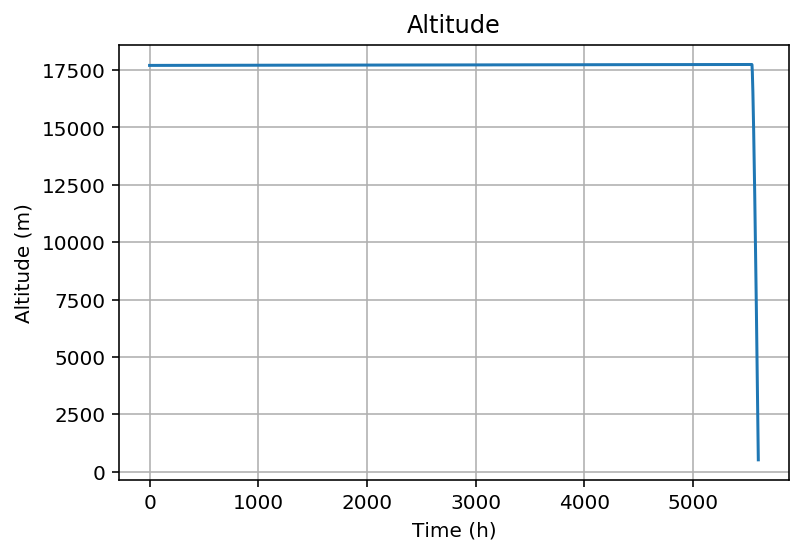

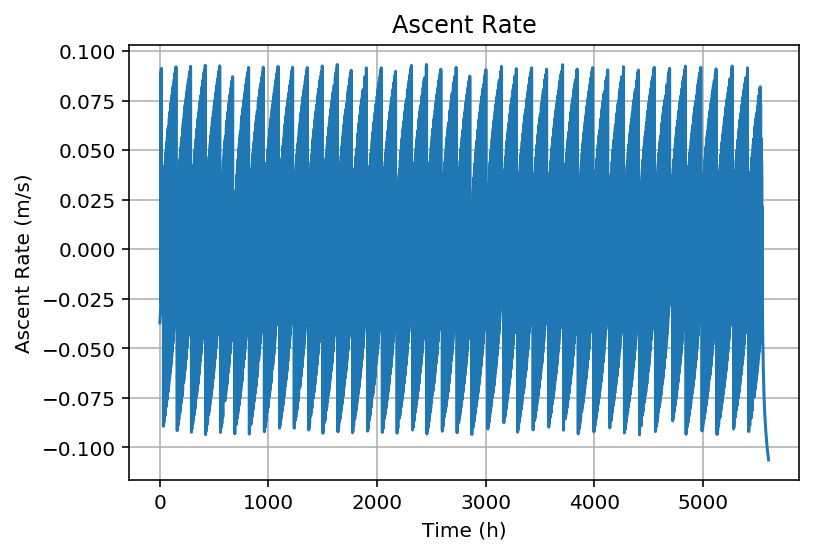

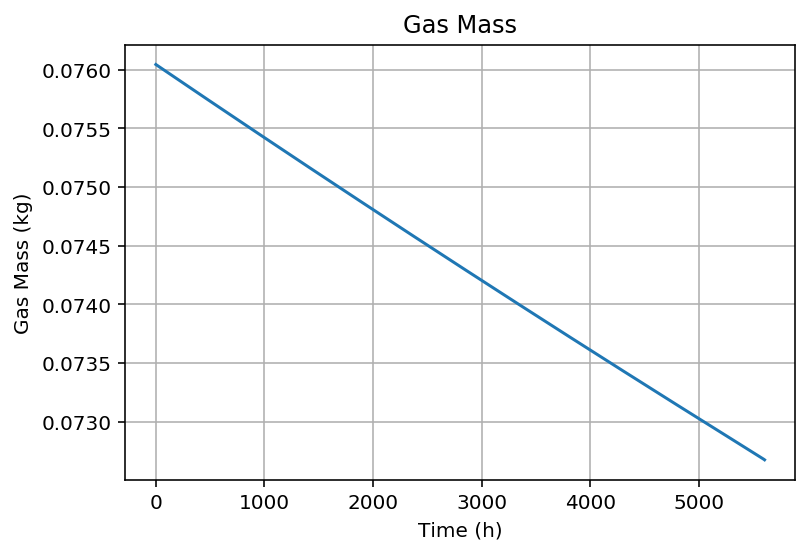

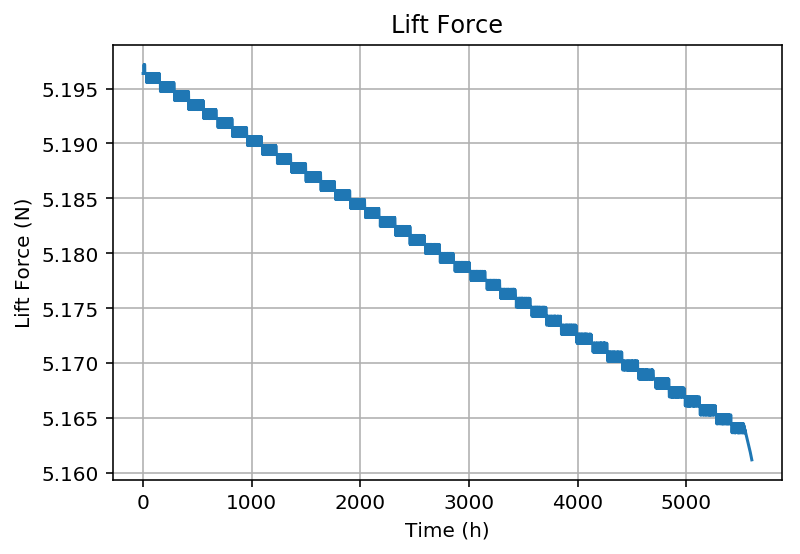

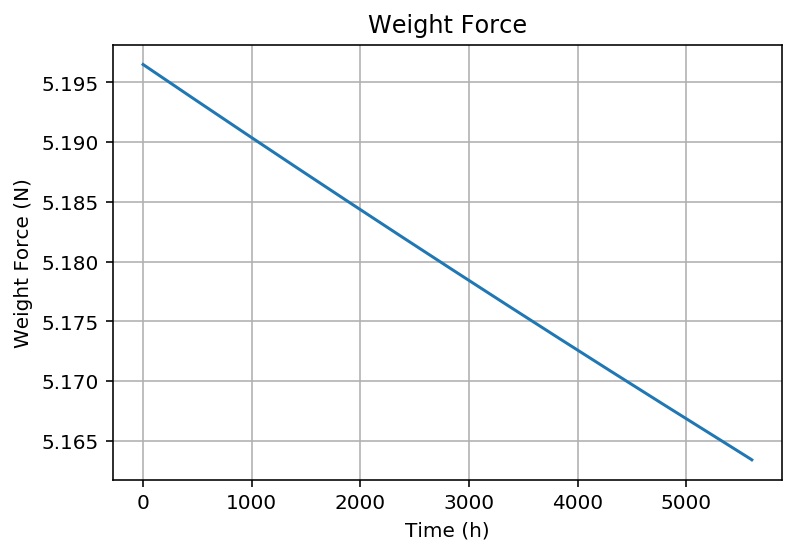

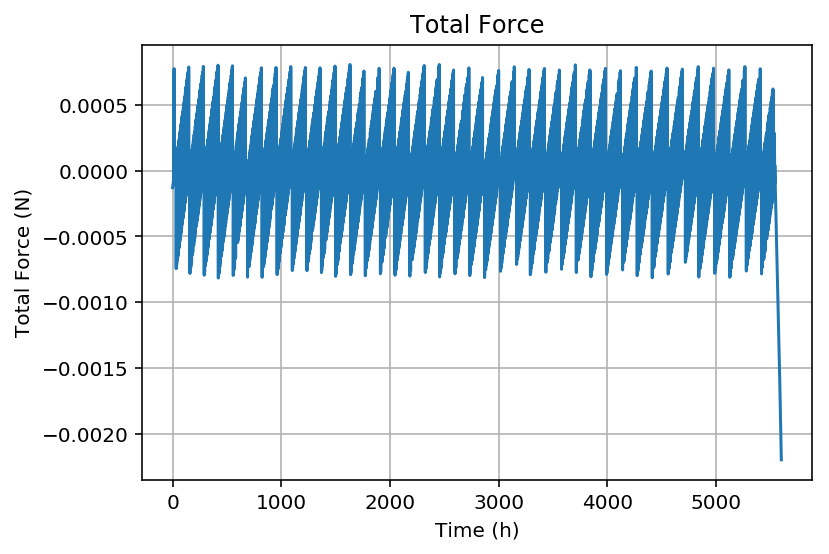

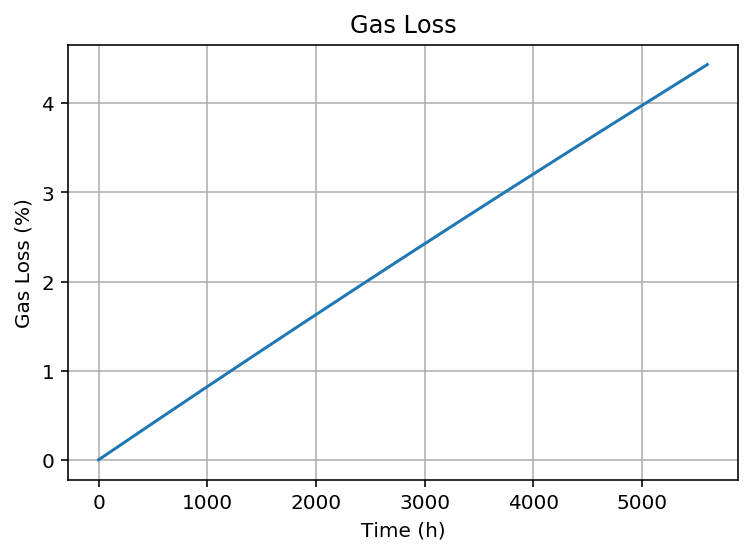

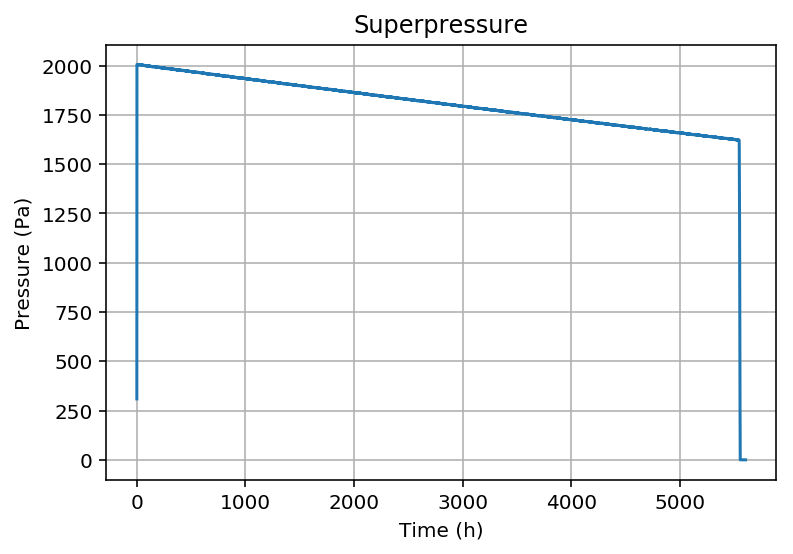

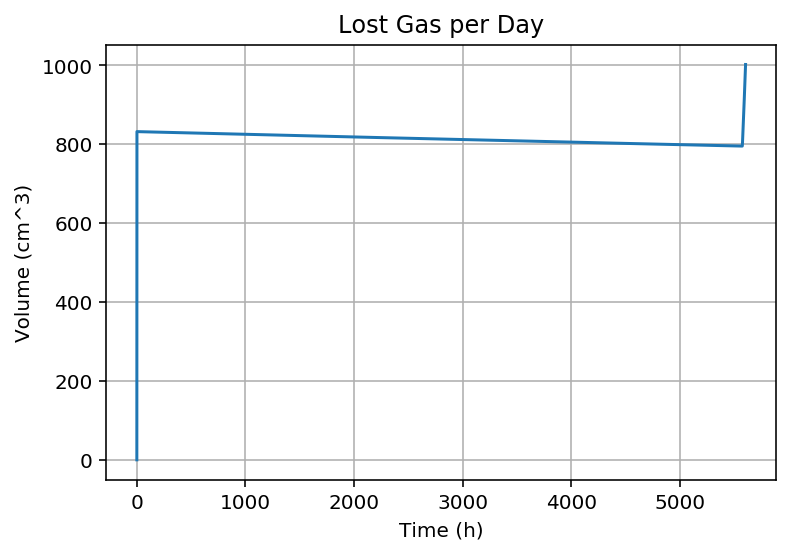

In [7]:
datapoints = 24000
factor = 3600
showFrom = 0

data = np.zeros((8, datapoints))
axis = np.linspace(0, datapoints-1, num=datapoints)

x = gasLoss(data, 86400000, factor, 4.18879, 0.44366828, 0.010, 0.076046, 17698.0, \
            'helium', 45.0, 680.0)

x = int(x / factor)

showTo = x   # n or x

print("Maximum Altitude:\t{0:.0f}\tm\t({1:.0f} m difference)" \
      .format(np.amax(data[0]), np.amax(data[0])-data[0][0]))
print("Time to Max. Alt.:\t{0:.0f}\th\t({1:.1f} days)" \
      .format(np.argmax(data[0]), np.argmax(data[0]) / 24.0))
print("Gas Loss to Failure:\t{0:.2f}\t%" \
      .format(np.amax(data[5])))

plt.plot(axis[showFrom:showTo], data[0][showFrom:showTo])
plt.title('Altitude')
plt.xlabel('Time (h)')
plt.ylabel('Altitude (m)')
plt.grid()
plt.show()

plt.plot(axis[showFrom:showTo], data[1][showFrom:showTo])
plt.title('Ascent Rate')
plt.xlabel('Time (h)')
plt.ylabel('Ascent Rate (m/s)')
plt.grid()
plt.show()

plt.plot(axis[showFrom:showTo], data[2][showFrom:showTo])
plt.title('Gas Mass')
plt.xlabel('Time (h)')
plt.ylabel('Gas Mass (kg)')
plt.grid()
plt.show()

plt.plot(axis[showFrom:showTo], data[3][showFrom:showTo])
plt.title('Lift Force')
plt.xlabel('Time (h)')
plt.ylabel('Lift Force (N)')
plt.grid()
plt.show()

plt.plot(axis[showFrom:showTo], data[4][showFrom:showTo])
plt.title('Weight Force')
plt.xlabel('Time (h)')
plt.ylabel('Weight Force (N)')
plt.grid()
plt.show()

plt.plot(axis[showFrom:showTo], data[3][showFrom:showTo]-data[4][showFrom:showTo])
plt.title('Total Force')
plt.xlabel('Time (h)')
plt.ylabel('Total Force (N)')
plt.grid()
plt.show()

plt.plot(axis[showFrom:showTo], data[5][showFrom:showTo])
plt.title('Gas Loss')
plt.xlabel('Time (h)')
plt.ylabel('Gas Loss (%)')
plt.grid()
plt.show()

plt.plot(axis[showFrom:showTo], data[6][showFrom:showTo])
plt.title('Superpressure')
plt.xlabel('Time (h)')
plt.ylabel('Pressure (Pa)')
plt.grid()
plt.show()

plt.plot(axis[showFrom:showTo], data[7][showFrom:showTo])
plt.title('Lost Gas per Day')
plt.xlabel('Time (h)')
plt.ylabel('Volume (cm^3)')
plt.grid()
plt.show()